In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql

In [2]:
database = "data/score.db"
connection =sql.connect(database)
query = '''SELECT * FROM score'''
df = pd.read_sql_query(query,connection)
df.head() #ensure that the data is properly loaded

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


In [3]:
print(len(df))

15900


# Part 1| Data Cleaning

The features can be split into three types of data namely; 
1. Numerical, 2. Binary and 3. Categorical

Index number is a unique key ID which has not much relevance (Rec to remove)

Target Variable: Final_test

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm,skew
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss

In [5]:
df.dtypes #check what type of features we are dealing with

index                   int64
number_of_siblings      int64
direct_admission       object
CCA                    object
learning_style         object
student_id             object
gender                 object
tuition                object
final_test            float64
n_male                float64
n_female              float64
age                   float64
hours_per_week        float64
attendance_rate       float64
sleep_time             object
wake_time              object
mode_of_transport      object
bag_color              object
dtype: object

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace =True)
missing_value_df

,column_name,percent_missing
index,index,0.000000
wake_time,wake_time,0.000000
sleep_time,sleep_time,0.000000
hours_per_week,hours_per_week,0.000000
age,age,0.000000
n_female,n_female,0.000000
n_male,n_male,0.000000
mode_of_transport,mode_of_transport,0.000000
bag_color,bag_color,0.000000
gender,gender,0.000000


We can see that both attendance_rate and final_test has empty values. In order to determine if median or mode fill should be used, a hisotogram plot will determine if each features are filled with outliers

<ipython-input-7-0667065ac35b>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)


Text(0.5, 1.0, 'attendance_rate Distribution')

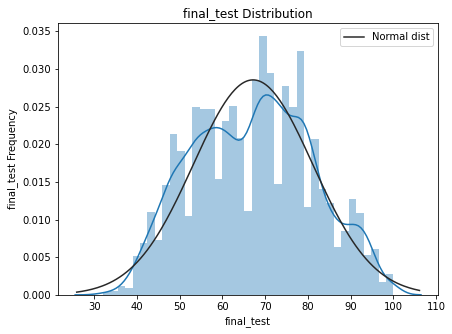

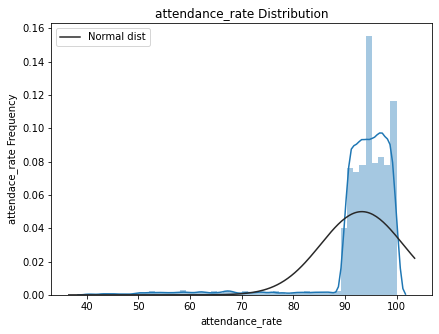

In [7]:
fig =plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['final_test'], fit=norm);
plt.legend(['Normal dist'],loc='best')
plt.ylabel('final_test Frequency')
plt.title('final_test Distribution')
plt.subplot(1,2,1)

fig =plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
sns.distplot(df['attendance_rate'], fit=norm);
plt.legend(['Normal dist'],loc='best')
plt.ylabel('attendace_rate Frequency')
plt.title('attendance_rate Distribution')

There is not need to do any log transformation on the target feature as the feature is already normally ditributed.

Conclusion: Use mean fill for final test as the tests are normally distributed and, use median fill for attendace rate as they are negatively skewed.

In [8]:
df['final_test']=df['final_test'].fillna(df['final_test'].mean())
df['attendance_rate']=df['attendance_rate'].fillna(df['attendance_rate'].median())
#check if any null left
df.isnull().sum()

index                 0
number_of_siblings    0
direct_admission      0
CCA                   0
learning_style        0
student_id            0
gender                0
tuition               0
final_test            0
n_male                0
n_female              0
age                   0
hours_per_week        0
attendance_rate       0
sleep_time            0
wake_time             0
mode_of_transport     0
bag_color             0
dtype: int64

## Check for duplicates

It is unlikely that there will be duplicates across every feature, should there be 1, it will liklely be an abnomally.

In [9]:
dupdf= df[df.duplicated()]
print(dupdf)

Empty DataFrame
Columns: [index, number_of_siblings, direct_admission, CCA, learning_style, student_id, gender, tuition, final_test, n_male, n_female, age, hours_per_week, attendance_rate, sleep_time, wake_time, mode_of_transport, bag_color]
Index: []


# Part 2 | Feature visualisation + Engineering

Starting off with a heatmap of numerical features. We will analyse each feature individually to see if there are any insights to be derived.

In addition, additional features will be engineered that will supposedly help improve the interpretability of the dataset. Optimistically, these features should also help to improve the performance of data.

## Feature creation: Sleeping time, total hours
Since sleep and wake time are both objects, have to convert them to strings then to integer. 
Studies have also shown that students who have longer sleep tend to do better at school, therefore a new feature hours_slept will be created.

In [10]:
df

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,95.0,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15895,15895,1,No,Clubs,Visual,XPECN2,Female,No,56.0,12.0,14.0,16.0,9.0,96.0,22:00,6:00,private transport,black
15896,15896,1,Yes,None,Auditory,7AMC7S,Male,Yes,85.0,17.0,5.0,16.0,7.0,91.0,22:30,6:30,private transport,white
15897,15897,1,Yes,Sports,Auditory,XKZ6VN,Female,Yes,76.0,7.0,10.0,15.0,7.0,93.0,23:00,7:00,walk,red
15898,15898,1,No,Clubs,Visual,2OU4UQ,Male,Yes,45.0,18.0,12.0,16.0,3.0,94.0,23:00,7:00,walk,yellow


In [11]:
from datetime import datetime, timedelta

df['col'] = pd.to_datetime(df['sleep_time'])
df['col2'] = pd.to_datetime(df['wake_time'])
df['datetime_sleep'] = df['col'].dt.strftime('%H:%M')
df['datetime_wake'] = df['col2'].dt.strftime('%H:%M')
#(df.fr-df.to).astype('timedelta64[h]')
df['col_hr'] = df.col.dt.hour
df['col_min'] = df.col.dt.minute
df['col2_hr'] = df.col2.dt.hour
df['col2_min'] = df.col2.dt.minute

#add 24 to wake hours
df['col2_hr']=df['col2_hr']+24
df['total_sleep_hr']= df["col2_hr"] - df["col_hr"]
# mins
df['total_sleep_mins']=df["col2_min"] - df["col_min"]

<ipython-input-12-d0db864fb3c5>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Type_new = pd.Series([])
C:\Users\tan_k\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


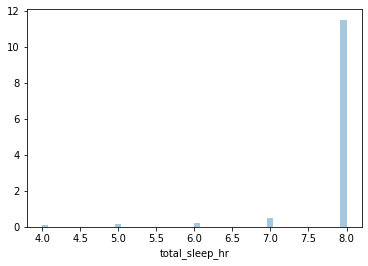

In [12]:
# importing pandas module
import pandas as pd
 
# creating a blank series
Type_new = pd.Series([])
 
# running a for loop and assigning some values to series
for i in range(len(df)):
    if df["total_sleep_hr"][i] > 20 :
        Type_new[i]=df["total_sleep_hr"][i] - 24

    else:
        Type_new[i]= df["total_sleep_hr"][i]
        
df['total_sleep_hr'] = Type_new
sns.distplot(df['total_sleep_hr']) # ensure that there are no abnomallies in total sleeping hours

In [13]:
df=df.drop(['col', 'col2','datetime_sleep','datetime_wake','col_min','col_hr','col2_hr','col2_min'], axis=1)

In [14]:
df

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color,total_sleep_hr,total_sleep_mins
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow,8,0
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green,8,0
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white,8,0
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,95.0,21:00,5:00,public transport,yellow,8,0
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15895,15895,1,No,Clubs,Visual,XPECN2,Female,No,56.0,12.0,14.0,16.0,9.0,96.0,22:00,6:00,private transport,black,8,0
15896,15896,1,Yes,None,Auditory,7AMC7S,Male,Yes,85.0,17.0,5.0,16.0,7.0,91.0,22:30,6:30,private transport,white,8,0
15897,15897,1,Yes,Sports,Auditory,XKZ6VN,Female,Yes,76.0,7.0,10.0,15.0,7.0,93.0,23:00,7:00,walk,red,8,0
15898,15898,1,No,Clubs,Visual,2OU4UQ,Male,Yes,45.0,18.0,12.0,16.0,3.0,94.0,23:00,7:00,walk,yellow,8,0


In [15]:
#df['sleep_time'] = df['sleep_time'].str.replace(r':', '') #remove all colon
#df['wake_time'] = df['wake_time'].str.replace(r':', '') #remove all colon
#df['sleep_time']=df['sleep_time'].astype(int) #convert to int
#df['wake_time']=df['wake_time'].astype(int) #convert to int

## Feature visualisation: Numerical Features

In [16]:
numerical=['number_of_siblings','final_test','n_male','n_female','age','hours_per_week','attendance_rate','total_sleep_hr']
num_df=df[numerical]

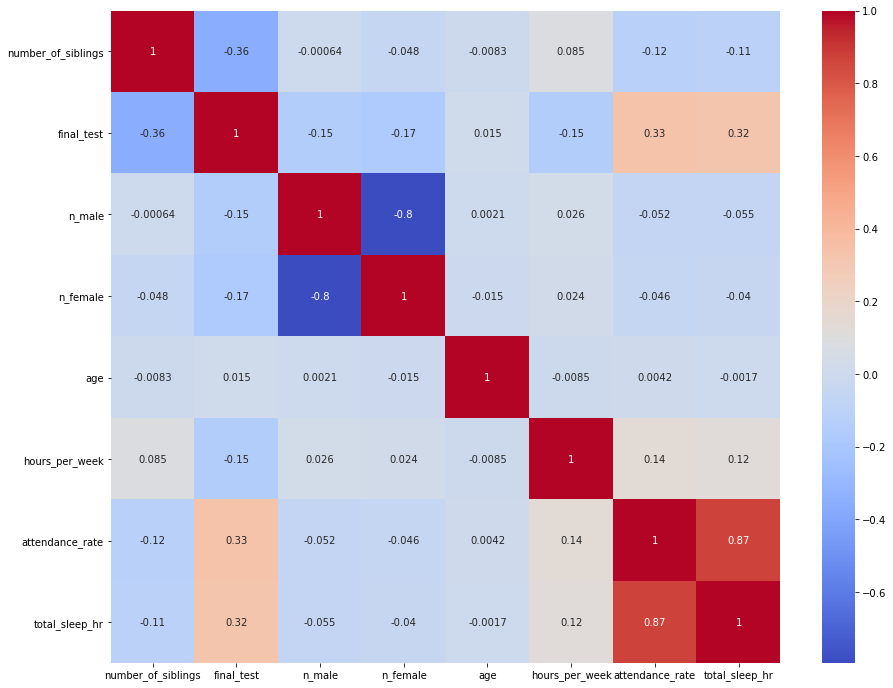

In [17]:
plt.figure(figsize=(15,12))
sns.heatmap(num_df.corr(), cmap="coolwarm", annot=True)

Typically, if features have higher correlation with each other. it will be wise to prevent multi-colinearity. However, in this case, there is no need as there are no feautures that are strongly correlated.

C:\Users\tan_k\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


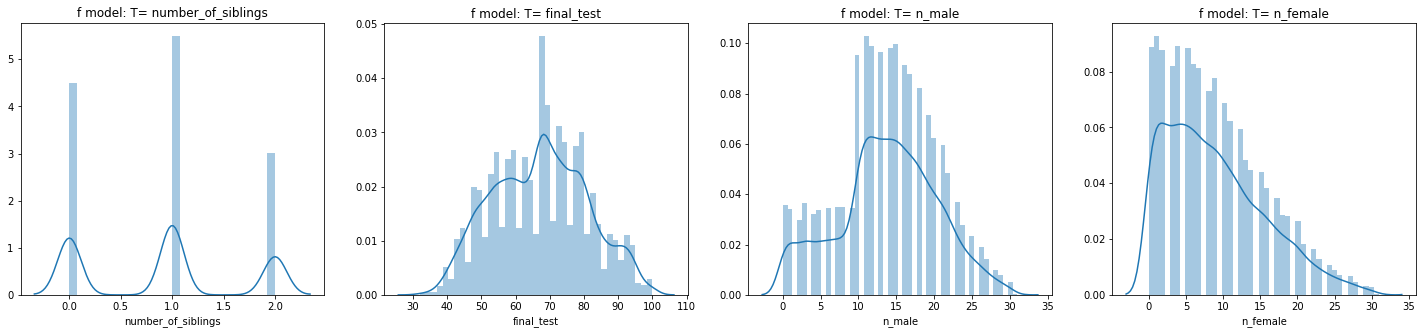

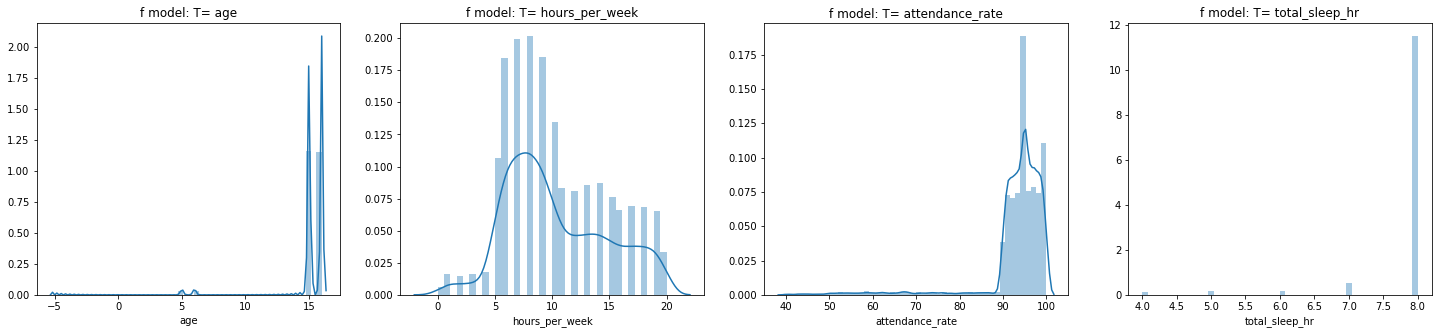

In [18]:
#vars = df.columns
vars = df[numerical].columns
figures_per_time = 4
count = 0 

for var in vars:
    x = df[var]
#     print(y.shape,x.shape)
    plt.figure(count//figures_per_time,figsize=(25,5))
    plt.subplot(1,figures_per_time,np.mod(count,4)+1)
    sns.distplot(x);
    plt.title('f model: T= {}'.format(var))
    count+=1

## Age
there seems to be some abnomalies present in age, as there are values such as 5,6,-4 etc. Removing them would make the data frame cleaner

In [28]:
df['age']=df['age'].astype(int)
df = df[df.age > 14]  

<ipython-input-28-38ac8b17f933>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age']=df['age'].astype(int)


## Feature elimination

### Index + Student ID

The indexes and student ID are unique key identifiers that should not provide much variance to our target feature.


In [20]:
df.drop(['index', 'student_id'], axis=1)

,number_of_siblings,direct_admission,CCA,learning_style,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color,total_sleep_hr,total_sleep_mins
0,0,Yes,Sports,Visual,Female,No,69.0,14.0,2.0,16,10.0,91.0,22:00,6:00,private transport,yellow,8,0
1,2,No,Sports,Auditory,Female,No,47.0,4.0,19.0,16,7.0,94.0,22:30,6:30,private transport,green,8,0
2,0,Yes,None,Visual,Male,No,85.0,14.0,2.0,15,8.0,92.0,22:30,6:30,private transport,white,8,0
3,1,No,Clubs,Auditory,Female,Yes,64.0,2.0,20.0,15,18.0,95.0,21:00,5:00,public transport,yellow,8,0
4,0,No,Sports,Auditory,Male,No,66.0,24.0,3.0,16,7.0,95.0,21:30,5:30,public transport,yellow,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15895,1,No,Clubs,Visual,Female,No,56.0,12.0,14.0,16,9.0,96.0,22:00,6:00,private transport,black,8,0
15896,1,Yes,None,Auditory,Male,Yes,85.0,17.0,5.0,16,7.0,91.0,22:30,6:30,private transport,white,8,0
15897,1,Yes,Sports,Auditory,Female,Yes,76.0,7.0,10.0,15,7.0,93.0,23:00,7:00,walk,red,8,0
15898,1,No,Clubs,Visual,Male,Yes,45.0,18.0,12.0,16,3.0,94.0,23:00,7:00,walk,yellow,8,0


## Feature analysis: Categorical Visualisation

## Mode of Transport

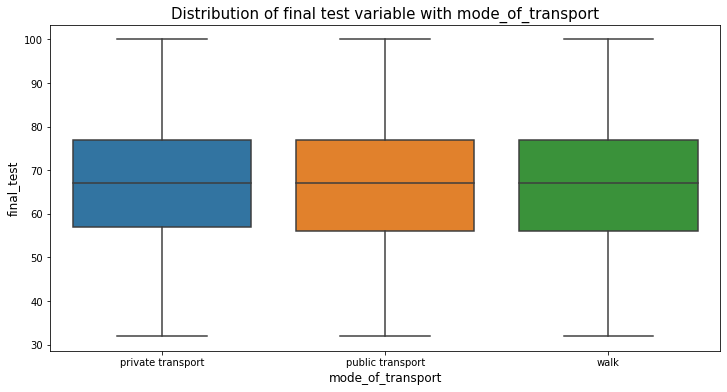

mode_of_transport
private transport    67.165401
public transport     67.165401
walk                 67.165401
Name: final_test, dtype: float64
mode_of_transport
private transport    190.672309
public transport     187.503031
walk                 188.773208
Name: final_test, dtype: float64


In [21]:
ranks = df.groupby("mode_of_transport")["final_test"].median().sort_values(ascending=False)[::-1].index

var_name = "mode_of_transport"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='final_test', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('final_test', fontsize=12)
plt.title("Distribution of final test variable with "+var_name, fontsize=15)
plt.show()
print(df.groupby("mode_of_transport")["final_test"].median())
print(df.groupby("mode_of_transport")["final_test"].var())

## Gender

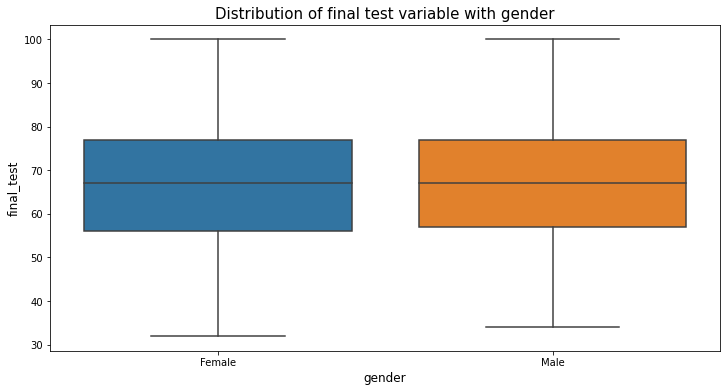

gender
Female    67.165401
Male      67.165401
Name: final_test, dtype: float64
gender
Female    190.557622
Male      187.424939
Name: final_test, dtype: float64


In [22]:
ranks = df.groupby("gender")["final_test"].median().sort_values(ascending=False)[::-1].index

var_name = "gender"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='final_test', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('final_test', fontsize=12)
plt.title("Distribution of final test variable with "+var_name, fontsize=15)
plt.show()
print(df.groupby("gender")["final_test"].median())
print(df.groupby("gender")["final_test"].var())

## CCA
CCA feature has some issues with encoding.

In [22]:
df["CCA"].replace({"CLUBS": "Clubs", "SPORTS": "Sports", "ARTS":"Arts","NONE":"None"}, inplace=True)

C:\Users\tan_k\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


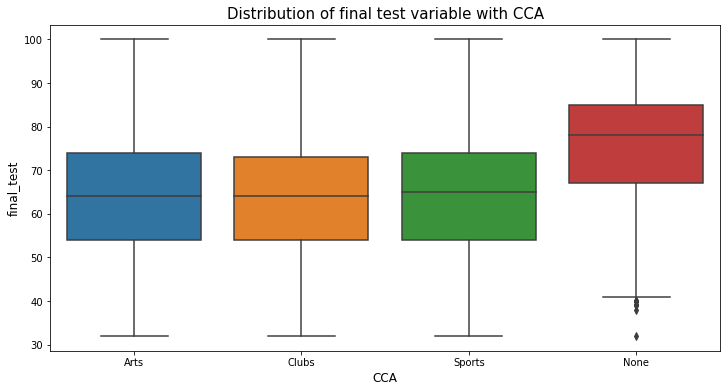

CCA
Arts      64.0
Clubs     64.0
None      78.0
Sports    65.0
Name: final_test, dtype: float64
CCA
Arts      168.101351
Clubs     164.042161
None      145.612971
Sports    164.190574
Name: final_test, dtype: float64


In [23]:
ranks = df.groupby("CCA")["final_test"].median().sort_values(ascending=False)[::-1].index

var_name = "CCA"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='final_test', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('final_test', fontsize=12)
plt.title("Distribution of final test variable with "+var_name, fontsize=15)
plt.show()
print(df.groupby("CCA")["final_test"].median())
print(df.groupby("CCA")["final_test"].var())

CCA feauture is useful as well in providing information. While it would be good to consider to classify it as having CCA and No CCA. I opted not to do so as there is some context to the features.

## Direction Admission

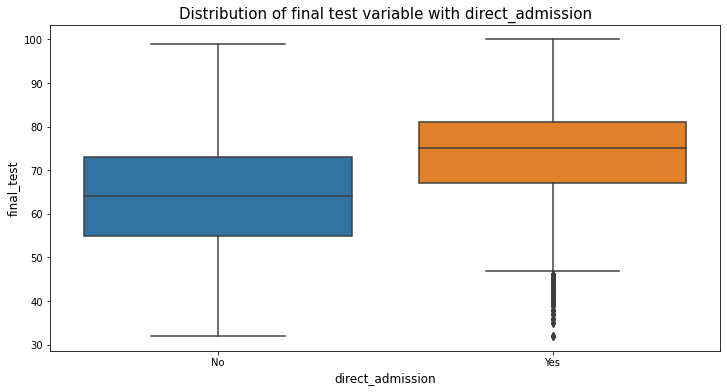

direct_admission
No     64.0
Yes    75.0
Name: final_test, dtype: float64
direct_admission
No     173.033399
Yes    191.774755
Name: final_test, dtype: float64


In [24]:
ranks = df.groupby("direct_admission")["final_test"].median().sort_values(ascending=False)[::-1].index

var_name = "direct_admission"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='final_test', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('final_test', fontsize=12)
plt.title("Distribution of final test variable with "+var_name, fontsize=15)
plt.show()
print(df.groupby("direct_admission")["final_test"].median())
print(df.groupby("direct_admission")["final_test"].var())

The direct admission feature is useful as it provides some variance to the final_test results.

## Tuition
There were some issues with the encoding so some data cleaning is required. group No and N together and Yes and Y together.

In [25]:
df["tuition"].replace({"No": "N", "Yes": "Y"}, inplace=True)

C:\Users\tan_k\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


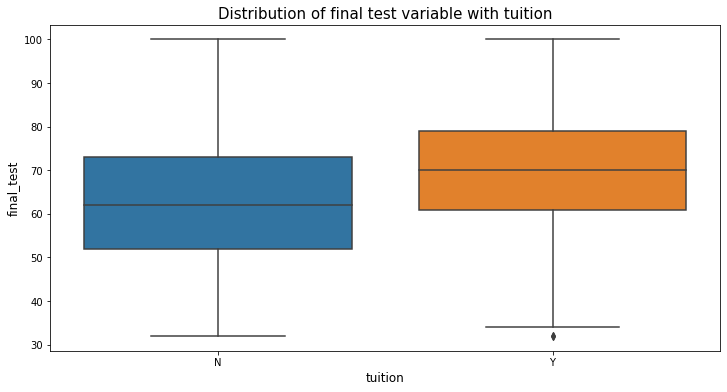

tuition
N    62.0
Y    70.0
Name: final_test, dtype: float64
tuition
N    196.578794
Y    159.450994
Name: final_test, dtype: float64


In [26]:
ranks = df.groupby("tuition")["final_test"].median().sort_values(ascending=False)[::-1].index

var_name = "tuition"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='final_test', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('final_test', fontsize=12)
plt.title("Distribution of final test variable with "+var_name, fontsize=15)
plt.show()
print(df.groupby("tuition")["final_test"].median())
print(df.groupby("tuition")["final_test"].var())

## Sleep Time

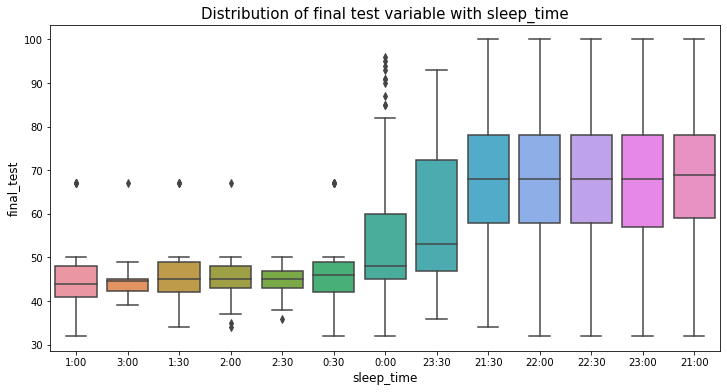

sleep_time
0:00     48.0
0:30     46.0
1:00     44.0
1:30     45.0
21:00    69.0
21:30    68.0
22:00    68.0
22:30    68.0
23:00    68.0
23:30    53.0
2:00     45.0
2:30     45.0
3:00     44.5
Name: final_test, dtype: float64
sleep_time
0:00     177.901012
0:30      39.660969
1:00      33.248250
1:30      35.478886
21:00    164.414363
21:30    172.517316
22:00    172.964670
22:30    182.363805
23:00    181.654764
23:30    262.122414
2:00      18.985347
2:30      13.021645
3:00      33.632063
Name: final_test, dtype: float64


In [23]:
ranks = df.groupby("sleep_time")["final_test"].median().sort_values(ascending=False)[::-1].index

var_name = "sleep_time"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='final_test', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('final_test', fontsize=12)
plt.title("Distribution of final test variable with "+var_name, fontsize=15)
plt.show()
print(df.groupby("sleep_time")["final_test"].median())
print(df.groupby("sleep_time")["final_test"].var())

As there is a distinct difference in the median test scores between the pre and post midnight category, i will group them into before midnight and after midnight.

In [24]:
df["sleep_time"].replace({"1:00": "Past_midnight", "3:00": "Past_midnight", "1:30":"Past_midnight","2:00":"Past_midnight","2:30":"Past_midnight","0:30":"Past_midnight","23:30": "Pre_midnight", "21:30": "Pre_midnight", "22:00":"Pre_midnight","21:00":"Pre_midnight","23:00":"Pre_midnight","0:00":"Pre_midnight","22:30":"Pre_midnight"}, inplace=True)

C:\Users\tan_k\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


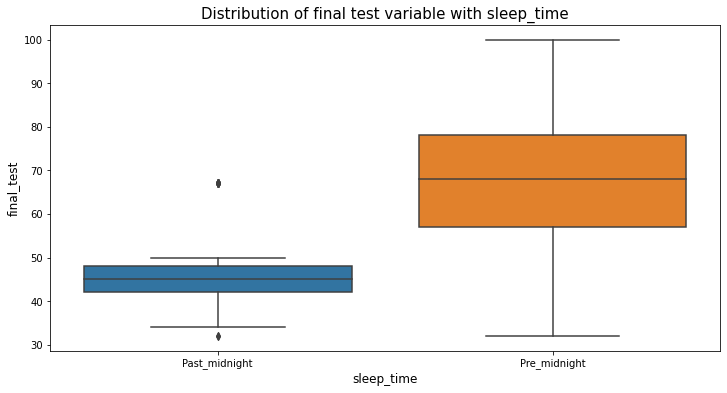

sleep_time
Past_midnight    45.0
Pre_midnight     68.0
Name: final_test, dtype: float64
sleep_time
Past_midnight     31.124727
Pre_midnight     180.141713
Name: final_test, dtype: float64


In [25]:
ranks = df.groupby("sleep_time")["final_test"].median().sort_values(ascending=False)[::-1].index

var_name = "sleep_time"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='final_test', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('final_test', fontsize=12)
plt.title("Distribution of final test variable with "+var_name, fontsize=15)
plt.show()
print(df.groupby("sleep_time")["final_test"].median())
print(df.groupby("sleep_time")["final_test"].var())

We can see that this new feature created shows a sharp distincition in both categories.

## Wake Time

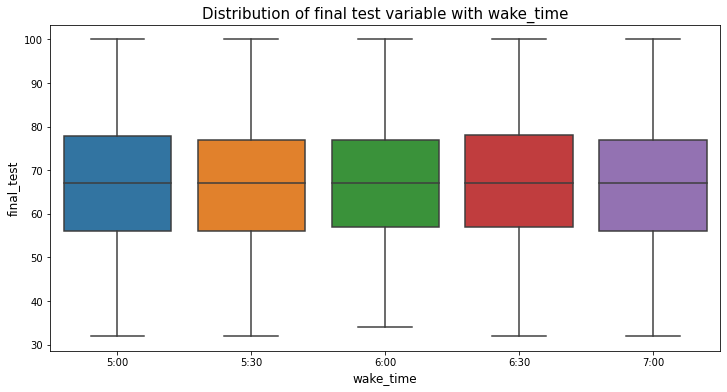

wake_time
5:00    67.165401
5:30    67.165401
6:00    67.165401
6:30    67.165401
7:00    67.165401
Name: final_test, dtype: float64
wake_time
5:00    186.074121
5:30    189.036915
6:00    185.642592
6:30    195.741764
7:00    188.773208
Name: final_test, dtype: float64


In [28]:
ranks = df.groupby("wake_time")["final_test"].median().sort_values(ascending=False)[::-1].index

var_name = "wake_time"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='final_test', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('final_test', fontsize=12)
plt.title("Distribution of final test variable with "+var_name, fontsize=15)
plt.show()
print(df.groupby("wake_time")["final_test"].median())
print(df.groupby("wake_time")["final_test"].var())

The variance across multiple waking times do not contribute to any large variance in the final score. Further more we have already created a new feature utilizing waking time. Therefore, wake _time can be removed.

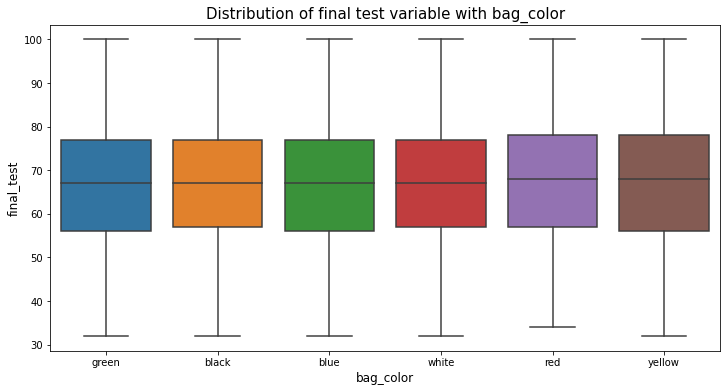

sleep_time
0:00     48.0
0:30     46.0
1:00     44.0
1:30     45.0
21:00    69.0
21:30    68.0
22:00    68.0
22:30    68.0
23:00    68.0
23:30    53.0
2:00     45.0
2:30     45.0
3:00     44.5
Name: final_test, dtype: float64
sleep_time
0:00     177.901012
0:30      39.660969
1:00      33.248250
1:30      35.478886
21:00    164.414363
21:30    172.517316
22:00    172.964670
22:30    182.363805
23:00    181.654764
23:30    262.122414
2:00      18.985347
2:30      13.021645
3:00      33.632063
Name: final_test, dtype: float64


In [34]:
ranks = df.groupby("bag_color")["final_test"].median().sort_values(ascending=False)[::-1].index

var_name = "bag_color"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var_name, y='final_test', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('final_test', fontsize=12)
plt.title("Distribution of final test variable with "+var_name, fontsize=15)
plt.show()
print(df.groupby("bag_color")["final_test"].median())
print(df.groupby("bag_color")["final_test"].var())

Since the variance does not change across multiple bag colors it shows that bag colors is not significant as a feature. In addition, intuitively bag color has no relevance to final grades. Therefore, bag color feature can be removed.